Download torch and torchvision

In [1]:
# pip install torch
# pip install timm

In [2]:
# pip install torchvision

Initialization

In [3]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from transformers import Dinov2Model, AutoImageProcessor

In [4]:
from util import *

In [5]:
USE_GPU = True
dtype = torch.float32 
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    device = torch.device('cpu')
    print("No GPU available. Training will run on CPU.")

GPU: NVIDIA GeForce RTX 4080 is available.


If the output is "using device: cpu": download CUDA toolkit (https://developer.nvidia.com/cuda-downloads)
https://pytorch.org/get-started/locally/

In [ ]:
# data 
random_trans = [v2.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2)), 
                v2.RandomRotation(degrees=20),
                # v2.RandomErasing(p=0.5, scale=(0.05, 0.2), ratio=(0.8, 1.2)), 
                v2.RandomGrayscale(),
                v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
                v2.RandomHorizontalFlip(p=0.1)]

transform_train = v2.Compose([v2.ToImage(), 
                        v2.ToDtype(torch.float32, scale=True),
                        v2.RandomApply(random_trans, 0.5)])

transform_eval = v2.Compose([v2.ToImage(), 
                            v2.ToDtype(torch.float32, scale=True)])

In [7]:
class CropButtonDataset(Dataset):
    def __init__(self, data_dir, transform = None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]
    
    # return classes
    def classes(self):
        return self.data.classes

In [8]:
# creat a dictionary that maps index to label
data_dir='ClassificationDataset_label/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}

In [ ]:
button_train = CropButtonDataset('ClassificationDataset_label/train', transform=transform_train)
loader_train = DataLoader(button_train, batch_size=45, shuffle=True)

button_val = CropButtonDataset('ClassificationDataset_label/val', transform=transform_eval)
loader_val = DataLoader(button_val, batch_size=20, shuffle=True)

button_test = CropButtonDataset('ClassificationDataset_label/test', transform=transform_eval)
loader_test = DataLoader(button_test, batch_size=14, shuffle=False)

Check If load correctly

In [10]:
loader_train

In [11]:
for images, labels in loader_val:
    print("Batch loaded!")
    print("Images shape:", images.shape)
    print("Labels:", labels)
    break


Batch loaded!
Images shape: torch.Size([19, 3, 224, 224])
Labels: tensor([1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0])


Model setup

In [12]:
class Dinov2BinaryClassifier(nn.Module):
    def __init__(
        self,
        backbone_name: str = "facebook/dinov2-small",
        hidden_dim: int = 512,
        dropout_prob: float = 0.4,
    ):
        """
        Param:
            - backbone_name: Hugging Face Dinov2 
            - hidden_dim: hidden dim
            - dropout_prob: dropout ratio
        """
        super().__init__()
        # 1) data preprocessing (check next cell for deatils)
        self.processor = AutoImageProcessor.from_pretrained(backbone_name)

        # 2) load pretrained weight
        self.backbone = Dinov2Model.from_pretrained(backbone_name)

        # 3) Classification Head：CLS token -> hidden_dim -> ReLU -> Dropout
        self.classifier = nn.Sequential(
            nn.Linear(self.backbone.config.hidden_size, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_prob),
            nn.Linear(hidden_dim, 1),  # BCE 1 dim output
        )

    def forward(self, pixel_values: torch.Tensor) -> torch.Tensor:
        """
        Param:
            - pixel_values: shape = (batch_size, 3, image_size, image_size),
        Output:
            - logits: shape = (batch_size, 2) raw score
        """
        # 1) send input into Dinov2 backbone,get last_hidden_state
        #    outputs.last_hidden_state = (batch_size, seq_len, hidden_size)，
        #    seq_len = patch + 1（CLS token）
        outputs = self.backbone(pixel_values=pixel_values)
        last_hidden = outputs.last_hidden_state  # (B, seq_len, hidden)

        # 2) get CLS token：last_hidden[:, 0, :]
        cls_token = last_hidden[:, 0, :]  # (B, hidden_size)

        # 3) sends CLS toekn
        logits = self.classifier(cls_token)  # (B, 2)
        return logits

Check augmentation

In [13]:
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-small")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [14]:
# processor

test backbone

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model
model = Dinov2BinaryClassifier(
    backbone_name="facebook/dinov2-small",
    hidden_dim=512,
    dropout_prob=0.4).to(device)

dummy_images = torch.randn(2, 3, 224, 224).to(device)  # (B=2, C=3, H=224, W=224)

with torch.no_grad():
    logits = model(dummy_images)

print("Logits:", logits)
probs = torch.softmax(logits, dim=-1)
print("Probabilities:", probs)

Logits: tensor([[ 0.6304],
        [-0.1917]], device='cuda:0')
Probabilities: tensor([[1.],
        [1.]], device='cuda:0')


Find best hyperparameter

In [16]:
# arch = ("facebook/dinov2-small", 256, 0.4)
# best_model, best_params, best_training_data = hyperparameter_search(Dinov2BinaryClassifier, arch, loader_train, loader_val, device)

In [17]:
# check_accuracy_final(loader_test, best_model, True)

Train best model

In [18]:
final_model = Dinov2BinaryClassifier(hidden_dim=126, dropout_prob=0.5)

In [19]:
from torchinfo import summary
summary(final_model, input_size=(1, 3, 320, 320))

Layer (type:depth-idx)                                       Output Shape              Param #
Dinov2BinaryClassifier                                       [1, 1]                    --
├─Dinov2Model: 1-1                                           [1, 384]                  --
│    └─Dinov2Embeddings: 2-1                                 [1, 485, 384]             526,848
│    │    └─Dinov2PatchEmbeddings: 3-1                       [1, 484, 384]             226,176
│    │    └─Dropout: 3-2                                     [1, 485, 384]             --
│    └─Dinov2Encoder: 2-2                                    [1, 485, 384]             --
│    │    └─ModuleList: 3-3                                  --                        21,302,784
│    └─LayerNorm: 2-3                                        [1, 485, 384]             768
├─Sequential: 1-2                                            [1, 1]                    --
│    └─Linear: 2-4                                           [1, 126]       

In [20]:
# hard code best paramm
lr = 5e-05
wd= 2e-2
beta = (0.9, 0.998)

In [21]:
optimizer = torch.optim.AdamW(
            [
                {"params": final_model.backbone.parameters(), "lr": lr / 10},
                {"params": final_model.classifier.parameters(), "lr": lr},
            ],
            weight_decay=wd,
            betas= beta)
data = train(final_model, optimizer, loader_train, loader_val, device, epochs=20)

Iter: 1/40    |  Loss: 0.840288  |  Train Acc: 0.4884  |  Val Acc: 0.5789 
Sample preds : [32.9%, 33.7%, 42.3%, 35.4%, 45.0%, 28.1%, 47.4%, 46.4%, 46.9%, 47.5%, 45.1%, 46.7%, 48.9%, 48.9%, 44.0%, 52.4%, 41.6%, 37.5%, 35.4%]
Sample labels: [0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]
Iter: 2/40    |  Loss: 0.692584  |  Train Acc: 0.5349  |  Val Acc: 0.4211 
Iter: 3/40    |  Loss: 0.743433  |  Train Acc: 0.6163  |  Val Acc: 0.4211 
Sample preds : [47.9%, 41.6%, 39.1%, 45.8%, 46.9%, 39.1%, 49.1%, 36.0%, 35.2%, 47.7%, 44.8%, 37.4%, 54.1%, 43.7%, 44.2%, 34.2%, 50.5%, 35.1%, 45.3%]
Sample labels: [0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0]
Iter: 4/40    |  Loss: 0.635919  |  Train Acc: 0.6744  |  Val Acc: 0.5789 
Iter: 5/40    |  Loss: 0.574400  |  Train Acc: 0.6279  |  Val Acc: 0.5789 
Sample preds : [51.8%, 46.2%, 49.0%, 53.5%, 37.1%, 35.2%, 37.0%, 46.2%, 31.3%, 46.0%, 31.3%, 45.4%, 43.4%

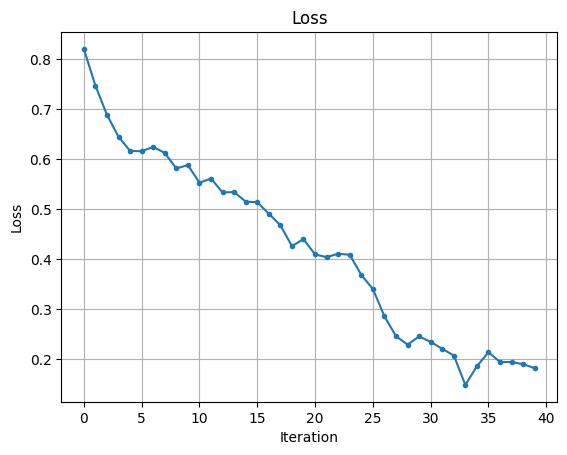

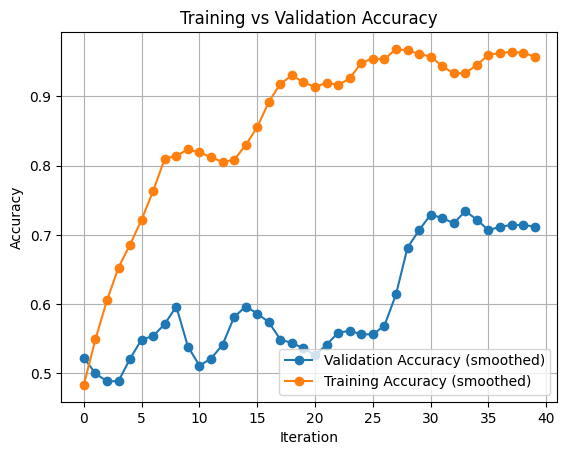

In [22]:
plotpic(data)

In [23]:
check_accuracy_final(loader_test, final_model, device, out=True)

Sample preds : [41.6%, 4.1%, 3.4%, 3.1%, 51.0%, 86.8%, 40.8%, 56.4%, 57.5%, 97.5%, 94.9%, 93.6%, 51.4%, 89.1%]
Sample labels: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


0.8571428571428571

In [24]:
def show_predictions_grid(loader, model, class_names=None, max_images=12, images_per_row=3):
    model.eval()
    images_shown = 0

    all_imgs = []
    all_titles = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            scores = model(x)
            probs = torch.sigmoid(scores)
            preds = (probs > 0.5).long().squeeze(1)

            for i in range(x.size(0)):
                if images_shown >= max_images:
                    break

                img = x[i].cpu()
                np_img = img.permute(1, 2, 0).numpy()

                pred_label = preds[i].item()
                true_label = y[i].item()
                pred_text = class_names[pred_label] if class_names else str(pred_label)
                true_text = class_names[true_label] if class_names else str(true_label)
                title = f"Pred: {pred_text} / GT: {true_text}"

                all_imgs.append(np_img)
                all_titles.append(title)
                images_shown += 1
            if images_shown >= max_images:
                break

    num_cols = images_per_row
    num_rows = (len(all_imgs) + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows))

    for i, ax in enumerate(axes.flat):
        if i < len(all_imgs):
            ax.imshow(all_imgs[i])
            ax.set_title(all_titles[i], fontsize=10)
            ax.axis("off")
        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

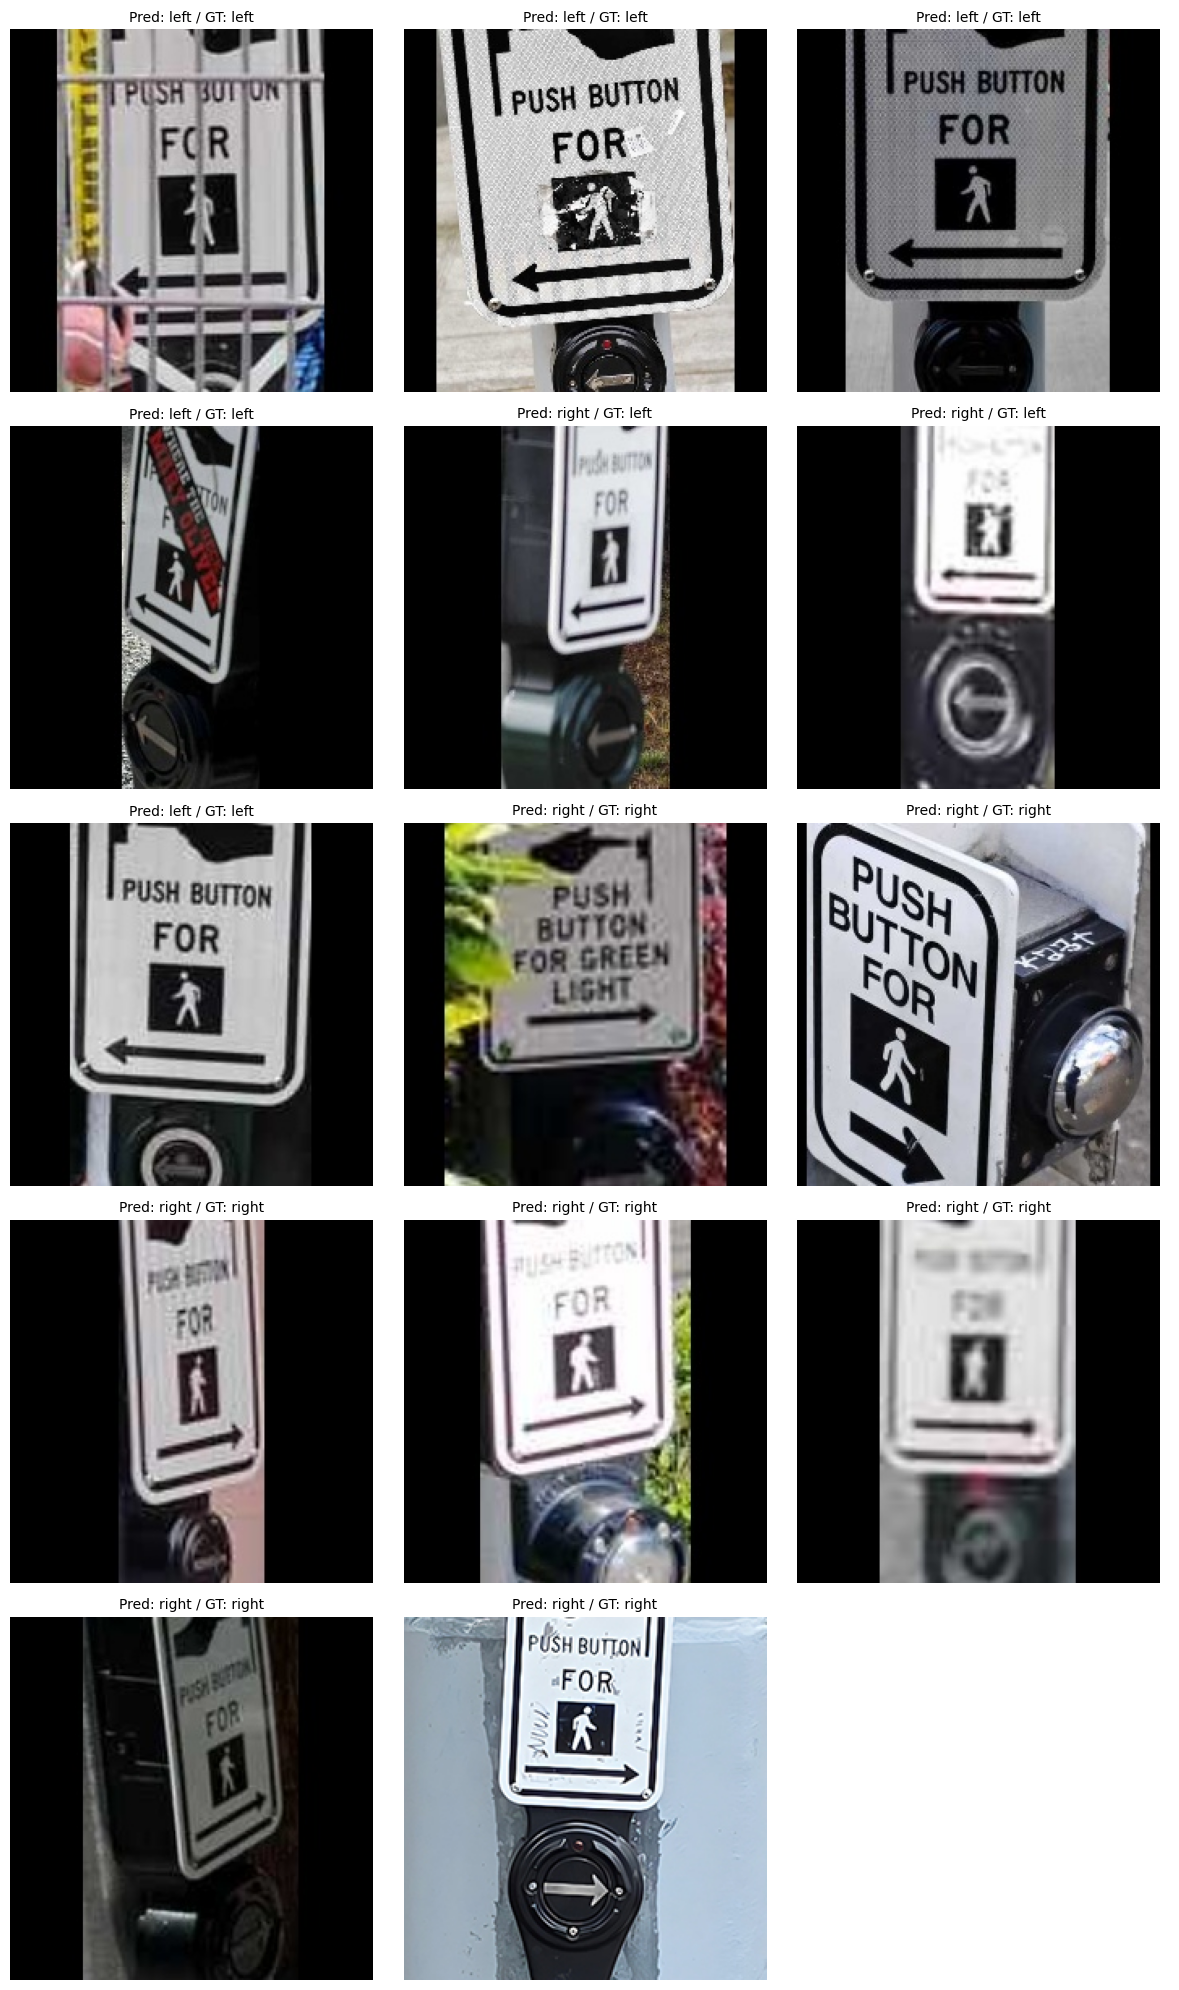

In [25]:
show_predictions_grid(loader_test, final_model, class_names=['left', 'right'], max_images=14, images_per_row=3)

Save model

In [26]:
torch.save(final_model.state_dict(), "dinov2_small_weights.pth")